# Loan Data from Prosper Exploration
## by Jeff Mitchell

## Preliminary Wrangling

This dataset contains information on nearly 114,000 loans from Prosper. The dataset contains a lot of features and will require some wrangling before we can start analysing it.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
loans = pd.read_csv('prosperLoanData.csv')

In [3]:
# high-level overview of data shape and composition
print(loans.shape)
print(loans.dtypes)

(113937, 81)
ListingKey                              object
ListingNumber                            int64
ListingCreationDate                     object
CreditGrade                             object
Term                                     int64
LoanStatus                              object
ClosedDate                              object
BorrowerAPR                            float64
BorrowerRate                           float64
LenderYield                            float64
EstimatedEffectiveYield                float64
EstimatedLoss                          float64
EstimatedReturn                        float64
ProsperRating (numeric)                float64
ProsperRating (Alpha)                   object
ProsperScore                           float64
ListingCategory (numeric)                int64
BorrowerState                           object
Occupation                              object
EmploymentStatus                        object
EmploymentStatusDuration               float64


### What is the structure of your dataset?

There are 113,937 loans with 81 features for each loan. This is a lot of features and some are only relevant to certain periods of time (e.g. pre-2009, post-July 2009). These features include details such as Term, Loan status, Borrower rate, various scores and ratings, demographic features such as Occupation, Employment status, Home ownership, various credit scores and totals, income range and details specific to the loan.

### What is/are the main feature(s) of interest in your dataset?

I am most interested in finding out what features have the greatest impact on Loan Outcome Status, specifically on whether or not the loan is paid off.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

Features of interest in investigating Loan Outcome Status include the reason for the loan (ListingCategory), their employment status (EmploymentStatus), their credit scores, their monthly income, the amount of the loan (LoanOriginalAmount) and level of monthly payments (MonthlyLoanPayment). Other features that may also be worth investingating include the number of delinquincies, their debt-to-income ratio (DebtToIncomeRatio) and their home ownership status. I expect that borrowers with higher debt-to-income ratios, lower monthly income and lower credit scores are less likely to complete their loan payments.

### Initial cleaning

A quick visual assessment of the raw the data file shows that the data requires some initial cleaning before I can start analysing it. This will involve dropping unnecessary columns, cleaning column types and creating new columns to help with the analysis.

There are a lot of columns in the data which makes useful analysis difficult. I will start by reducing the dataframe to only the columns that are of interest to me for investigating the Loan Status Outcome. For example, LoanNumber can be used to identify individual loans. This removes the need to hold ListingNumber, ListingKey and LoanKey which are all associated with a unique LoanNumber.

In [4]:
# Reduce the number of columns to just those that may be of interest
columns = ['Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate', 'ListingCategory (numeric)', 'EmploymentStatus', 
           'IsBorrowerHomeowner', 'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'TotalCreditLinespast7years',
           'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'CurrentDelinquencies', 'DelinquenciesLast7Years', 
           'DebtToIncomeRatio', 'StatedMonthlyIncome', 'LoanNumber', 'LoanOriginalAmount', 'LoanOriginationQuarter',
           'MemberKey', 'MonthlyLoanPayment']
loans = loans[columns]

Some of the column headings are confusing or difficult to work with so I will rename them.

In [5]:
loans = loans.rename(columns={'ListingCategory (numeric)':'ListingCategory','IsBorrowerHomeowner':'HomeOwner',
                              'TotalCreditLinespast7years':'TotalCreditLines',
                              'DelinquenciesLast7Years':'TotalDelinquencies'})

I am interested in the effect of the features on Loan Outcome Status. Loans that have not yet reached an outcome need to be removed as I do not know what their final outcome will be (I cannot identify what effect their features have on Loan Outcome Status as their status is not yet known). First I will check the values in the LoanStatus column.

In [6]:
loans.LoanStatus.value_counts()

Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

For this analysis I am going to consider 'Chargedoff' and 'Defaulted' as loans that were not completed successfully. Loans that are 'Past Due...' I will consider current.The loans to be removed are those listed as 'Current', 'Past Due...' and 'FinalPaymentInProgress'. 

In [7]:
# Remove loans that have not reached an outcome
loans = loans[loans['LoanStatus'].isin(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'])]
loans.LoanStatus.value_counts()

Completed     38074
Chargedoff    11992
Defaulted      5018
Cancelled         5
Name: LoanStatus, dtype: int64

As I will be using LoanNumber to identify unique loans, I need to make sure there are no duplicated loan records.

In [8]:
dupes = loans[loans['LoanNumber'].duplicated() == True]
dupes

,Term,LoanStatus,BorrowerAPR,BorrowerRate,ListingCategory,EmploymentStatus,HomeOwner,CreditScoreRangeLower,CreditScoreRangeUpper,TotalCreditLines,...,OpenRevolvingMonthlyPayment,CurrentDelinquencies,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanNumber,LoanOriginalAmount,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment
33959,60,Completed,0.28875,0.2624,3,Employed,False,660.0,679.0,61.0,...,255.0,0.0,0.0,0.33,4506.666667,131358,5500,Q1 2014,85D535659273197054A0BB3,165.45
37956,36,Completed,0.22875,0.1915,1,Employed,False,660.0,679.0,19.0,...,459.0,0.0,0.0,0.20,6083.333333,105288,20000,Q4 2013,8EC335867884136891E9E14,734.64
51079,36,Completed,0.23438,0.1970,1,Employed,True,660.0,679.0,43.0,...,1027.0,0.0,0.0,0.16,14583.333333,123094,5000,Q4 2013,9FA83698836314377793393,185.05
60004,36,Completed,0.13799,0.1099,7,Employed,True,680.0,699.0,21.0,...,237.0,0.0,1.0,0.23,4250.000000,110303,2000,Q4 2013,4553358888719707373CD1C,65.47
61289,36,Completed,0.09000,0.0766,1,Self-employed,True,800.0,819.0,17.0,...,178.0,0.0,0.0,NaN,7500.000000,107275,3500,Q4 2013,34193560492599576667729,109.13
68585,36,Completed,0.18633,0.1500,1,Employed,False,700.0,719.0,40.0,...,604.0,0.0,0.0,0.34,7500.000000,121979,15000,Q4 2013,27FA3533700778342A3BB33,519.98
70435,60,Completed,0.19988,0.1760,1,Employed,True,720.0,739.0,26.0,...,159.0,2.0,0.0,0.26,4125.000000,119188,15000,Q4 2013,4FC835464074587007C7ABC,377.64
96475,60,Completed,0.22601,0.2015,1,Employed,False,680.0,699.0,20.0,...,506.0,0.0,0.0,0.23,4125.000000,101908,15000,Q3 2013,7EF83383685864632D111F0,398.66
97137,36,Completed,0.32446,0.2850,1,Employed,False,660.0,679.0,30.0,...,88.0,0.0,13.0,0.17,5833.333333,121751,4000,Q4 2013,4E9335537538907782E9392,166.54
97330,60,Completed,0.23318,0.2085,1,Employed,True,680.0,699.0,26.0,...,339.0,0.0,0.0,0.32,4166.666667,118909,13000,Q4 2013,117636957815160767DC8DC,350.60


There are 13 duplicated records in the data based on LoanNumber. A visual check of these in the raw data showed that the only difference between the duplicates was the ProsperScore, which is not being used in this analysis. For this reason we can drop the duplicate values.

In [9]:
# Drop rows duplicated on LoanNumber
loans.drop_duplicates('LoanNumber', inplace=True)

I am interested in knowing the outcome of the loan - if it was successfully paid off or not. This will be easiest by creating a new column that records the final status of the loan - LoanCompleted - which holds a string, either 'Completed' (paid off) or 'Not completed' (not paid off).

In [10]:
# Return loan completion status
def getLoanCompleted(loan_status):
    """Return True if loan completed, False otherwise."""
    if loan_status.strip() == 'Completed':
        return 'Completed'
    else:
        return 'Not completed'
    
# Create column to hold status of loan outcome
loans['LoanCompleted'] = loans['LoanStatus'].apply(getLoanCompleted)

# Drop LoanStatus column
loans.drop('LoanStatus', axis=1, inplace=True)

In [11]:
# Examine remaining columns
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55076 entries, 0 to 113935
Data columns (total 21 columns):
Term                           55076 non-null int64
BorrowerAPR                    55051 non-null float64
BorrowerRate                   55076 non-null float64
ListingCategory                55076 non-null int64
EmploymentStatus               52821 non-null object
HomeOwner                      55076 non-null bool
CreditScoreRangeLower          54485 non-null float64
CreditScoreRangeUpper          54485 non-null float64
TotalCreditLines               54379 non-null float64
OpenRevolvingAccounts          55076 non-null int64
OpenRevolvingMonthlyPayment    55076 non-null float64
CurrentDelinquencies           54379 non-null float64
TotalDelinquencies             54086 non-null float64
DebtToIncomeRatio              50847 non-null float64
StatedMonthlyIncome            55076 non-null float64
LoanNumber                     55076 non-null int64
LoanOriginalAmount             55076 n

Several of the columns will need some cleaning before we can perform analysis on them. Firstly we can convert the LoanNumber to a string as we are using it as a reference only.

In [12]:
# Convert LoanNumber to a string as we will not perform calcluations on it
loans['LoanNumber'] = loans['LoanNumber'].astype('str')

The Listing Category column currently only has ints. These will be much easier to analyse by converting them to a string that states what the int represents and then setting the column to category type.

In [13]:
# Convert the ListingCategory column to readable values
def convert_listing_category(cat):
    """Convert the listing category to a human-readable string."""
    categories = ['Not Available', 'Debt Consolidation', 'Home Improvement', 'Business', 'Personal Loan', 'Student Use',
                 'Auto', 'Other', 'Baby and Adoption', 'Boat', 'Cosmetic Procedure', 'Engagement Ring', 'Green Loans',
                 'Household Expense', 'Large Purchases', 'Medical and Dental', 'Motorcycle', 'RV', 'Taxes', 'Vacation',
                 'Wedding']
    return categories[cat]

loans['ListingCategory'] = loans['ListingCategory'].apply(convert_listing_category)

# Convert ListingCategoy to categorical types
loans['ListingCategory'] = loans['ListingCategory'].astype('category')

There are null values in the EmploymentStatus column so let's take a closer look at the column.

In [14]:
loans['EmploymentStatus'].value_counts()

Full-time        24958
Employed         16479
Not available     5347
Self-employed     2925
Part-time         1056
Other              798
Retired            697
Not employed       561
Name: EmploymentStatus, dtype: int64

The null values in EmploymentStatus can also be represented by the existing 'Not available' value, so these should be converted to be consistent and make analysis easier.

In [15]:
# Convert null EmploymentStatus to 'Not Available'
loans['EmploymentStatus'] = loans['EmploymentStatus'].fillna('Not available')

The categories are not particularly useful in their current form as it is not clear how to differenctiate from the 'Employed' category and 'Full-time', 'Part-time', 'Self-employed' etc. For this analysis I will convert the 'Employed' borrowers to 'Full-time' as it seems reasonable to assume that most employed borrorwers will be employed full-time, given that in the loan data they are 25 times more likely to be employed full-time than part-time. 

In [16]:
mask = loans['EmploymentStatus'] == 'Employed'
column_name = 'EmploymentStatus'
loans.loc[mask, column_name] = 'Full-time'

The column can now be converted to a category type which is more appropriate for this data.

In [17]:
# Convert EmploymentStatus to categorical type
loans['EmploymentStatus'] = loans['EmploymentStatus'].astype('category')

LoanOriginationQuarter can also be converted to a category type.

In [18]:
# Convert LoanOriginationQuarter to categorical type
loans['LoanOriginationQuarter'] = loans['LoanOriginationQuarter'].astype('category')

Loan Term may be a candidate for a category type if there are limited term options. Let's see.

In [19]:
loans.Term.value_counts()

36    49852
60     3692
12     1532
Name: Term, dtype: int64

There are only three possible terms, so these are better represented as categories

In [20]:
# Convert Term to categorical type
loans['Term'] = loans['Term'].astype('category')

The Credit Score will be more useful if there is one Credit Score value per loan, rather than a lower and upper value. A new column can be created that holds the mean of the lower and upper scores for each row.

In [21]:
# Function to calculate mean of lower and upper credit ratings
def get_rating(lower, upper):
    "Calculate mean of lower and upper credit ratings."
    mean = (lower + upper) / 2
    return mean

# Add CreditScore column and populate
loans['CreditScore'] = loans.apply(lambda x: get_rating(x['CreditScoreRangeLower'], x['CreditScoreRangeUpper']), axis=1)

# Drop unneeded Credit Range columns
loans.drop(['CreditScoreRangeLower','CreditScoreRangeUpper'], axis=1, inplace=True)

In [22]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55076 entries, 0 to 113935
Data columns (total 20 columns):
Term                           55076 non-null category
BorrowerAPR                    55051 non-null float64
BorrowerRate                   55076 non-null float64
ListingCategory                55076 non-null category
EmploymentStatus               55076 non-null category
HomeOwner                      55076 non-null bool
TotalCreditLines               54379 non-null float64
OpenRevolvingAccounts          55076 non-null int64
OpenRevolvingMonthlyPayment    55076 non-null float64
CurrentDelinquencies           54379 non-null float64
TotalDelinquencies             54086 non-null float64
DebtToIncomeRatio              50847 non-null float64
StatedMonthlyIncome            55076 non-null float64
LoanNumber                     55076 non-null object
LoanOriginalAmount             55076 non-null int64
LoanOriginationQuarter         55076 non-null category
MemberKey                     

### Missing Values

There are several columns that contain missing values. We need to address each of these individually.

There are 25 rows missing the BorrowerAPR. This is a very small percentage of the total so we can use the mean for the column to fill these values.

In [23]:
# Fill missing BorrowerAPR values with the mean for the columnm
mean_apr = loans.BorrowerAPR.mean()
loans['BorrowerAPR'] = loans.BorrowerAPR.fillna(mean_apr)

There are 591 rows missing Credit Score details. We should check what other information these rows are missing.

In [24]:
missing = loans[loans['CreditScore'].isnull() == True]
missing.head()

,Term,BorrowerAPR,BorrowerRate,ListingCategory,EmploymentStatus,HomeOwner,TotalCreditLines,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,CurrentDelinquencies,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanNumber,LoanOriginalAmount,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LoanCompleted,CreditScore
206,36,0.27767,0.2700,Not Available,Not available,False,NaN,0,0.0,NaN,NaN,0.16573,9166.666667,323,7500,Q1 2006,110A336465998424756030B,306.19,Not completed,NaN
387,36,0.09337,0.0865,Not Available,Not available,False,NaN,0,0.0,NaN,NaN,0.12624,3000.000000,174,3500,Q1 2006,69D933646754525905A852D,110.73,Completed,NaN
698,36,0.07680,0.0700,Not Available,Not available,False,NaN,0,0.0,NaN,NaN,0.02727,8333.333333,36,6001,Q1 2006,8DE133657363264326FD856,185.29,Completed,NaN
1023,36,0.08684,0.0800,Not Available,Not available,False,NaN,0,0.0,NaN,NaN,0.02480,8333.333333,396,5000,Q2 2006,6D11336601070734709170C,156.68,Completed,NaN
1126,36,0.20735,0.2000,Not Available,Not available,False,NaN,0,0.0,NaN,NaN,0.13759,4250.000000,202,2550,Q1 2006,EDAD3365722336384C605F7,94.77,Completed,NaN


We can see that these rows are missing all of their credit data along with Listing Category, Employment Status, Delinquincies etc. We can drop these rows from the data as they only represent around 1% of the target data and I do not want to introduce noise or errors by using the mean for these values. ListingCategory, EmploymentStatus and HomeOwner also cannot be adequately filled by a default value so it is best to drop these rows.

In [25]:
# Drop rows missing credit values
loans = loans[loans['CreditScore'].isnull() == False]

The remaining columns that have missing values can be dealt with when they are analysed - the null values can remain in place. Now we can look at an overview of the remaining data of interest

In [26]:
print(loans.shape)
print(loans.dtypes)
print(loans.head())

(54485, 20)
Term                           category
BorrowerAPR                     float64
BorrowerRate                    float64
ListingCategory                category
EmploymentStatus               category
HomeOwner                          bool
TotalCreditLines                float64
OpenRevolvingAccounts             int64
OpenRevolvingMonthlyPayment     float64
CurrentDelinquencies            float64
TotalDelinquencies              float64
DebtToIncomeRatio               float64
StatedMonthlyIncome             float64
LoanNumber                       object
LoanOriginalAmount                int64
LoanOriginationQuarter         category
MemberKey                        object
MonthlyLoanPayment              float64
LoanCompleted                    object
CreditScore                     float64
dtype: object
   Term  BorrowerAPR  BorrowerRate    ListingCategory EmploymentStatus  \
0    36      0.16516        0.1580      Not Available    Self-employed   
2    36      0.28269      

In [27]:
loans.describe()

,BorrowerAPR,BorrowerRate,TotalCreditLines,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,CurrentDelinquencies,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanOriginalAmount,MonthlyLoanPayment,CreditScore
count,54485.000000,54485.000000,54379.000000,54485.000000,54485.000000,54379.000000,54086.000000,50262.000000,54485.000000,54485.000000,54485.000000,54485.000000
mean,0.222646,0.200789,25.274977,6.143104,328.796550,0.906563,4.572385,0.291532,5043.489058,6274.071983,224.260224,681.235340
std,0.088089,0.081165,14.268204,4.508924,450.006566,2.596514,10.690307,0.740366,5713.731383,5225.328950,186.029469,81.917545
min,0.006530,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,0.000000,9.500000
25%,0.149900,0.135000,15.000000,3.000000,63.000000,0.000000,0.000000,0.130000,2804.166667,2600.000000,98.690000,649.500000
50%,0.214800,0.194900,23.000000,5.000000,186.000000,0.000000,0.000000,0.200000,4166.666667,4500.000000,172.760000,689.500000
75%,0.295250,0.269900,33.000000,8.000000,422.000000,1.000000,4.000000,0.300000,6250.000000,8000.000000,301.030000,729.500000
max,0.423950,0.360000,136.000000,51.000000,14985.000000,83.000000,99.000000,10.010000,618547.833333,35000.000000,2251.510000,889.500000


## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

I'll start by looking at the main variable of interest - the Loan Outcome Status

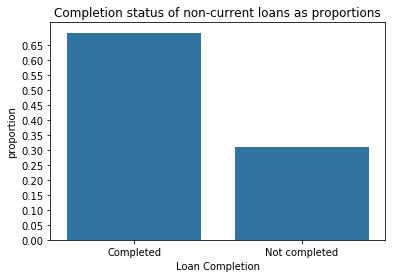

In [28]:
# Plot LoanCompleted column as %
base_color = sb.color_palette()[0]
n_points = loans.shape[0]
max_count = loans['LoanCompleted'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
sb.countplot(data = loans, x = 'LoanCompleted', color = base_color)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Loan Completion')
plt.title('Completion status of non-current loans as proportions');

We can see that close to 70% of the loans in the extracted data were completed and 30% were not completed (not paid off).

I'd like to check the distribution of some of the categorical variables next.

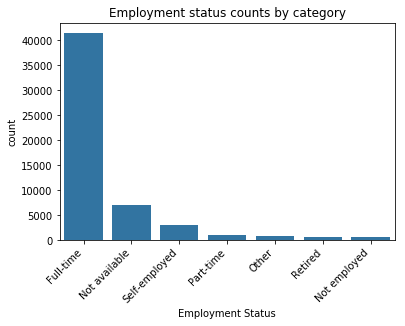

In [29]:
# Plot EmploymentStatus column
cat_order = loans['EmploymentStatus'].value_counts().index
sb.countplot(data = loans, x = 'EmploymentStatus', color = base_color, order=cat_order)
plt.xlabel('Employment Status')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Employment status counts by category');

We can see that most borrowers were involved in some form of employment, however, there was a large proportion that the employment status was unknown. It will be interesting to see if being employed full-time increases the likelihood of a loan being paid off.

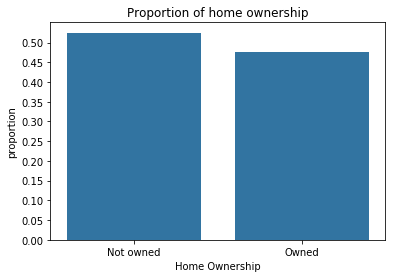

In [30]:
# Plot HomeOwnership column as %
n_points = loans.shape[0]
max_count = loans['HomeOwner'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
sb.countplot(data = loans, x = 'HomeOwner', color = base_color)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Home Ownership')
plt.xticks([0, 1], ['Not owned', 'Owned'])
plt.title('Proportion of home ownership');

Home ownership is split pretty evenly across the data.

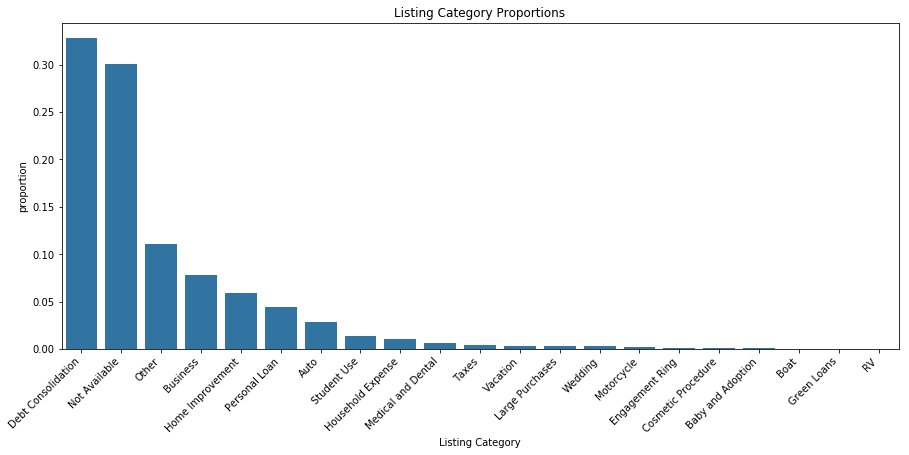

In [31]:
# Plot ListingCategory column as %
plt.figure(figsize=[15,6])
n_points = loans.shape[0]
cat_order = loans['ListingCategory'].value_counts().index
max_count = loans['ListingCategory'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
sb.countplot(data = loans, x = 'ListingCategory', color = base_color, order = cat_order)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Listing Category')
plt.xticks(rotation = 45, horizontalalignment='right')
plt.title('Listing Category Proportions');

Over a third of the Listing Categories fall under 'Debt Consolidation'. Another third is 'Not Available' and a large number are also 'Other' which is not very helpful for analysis. We may be able to look at the effect of the Debt Consolidation category on the outcome of a loan, however, most of the other categories are too underepresented to be able to draw many conclusions from.

Let's see if there are any trends in the Quarter the loans originated.

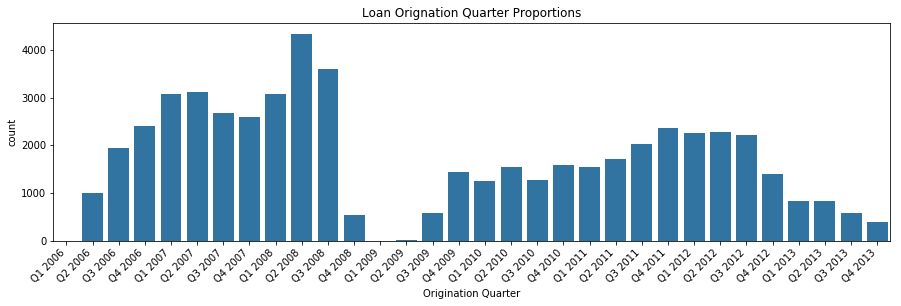

In [32]:
# Plot LoanOriginationQuarter column
plt.figure(figsize=[15,4])
cat_order = ['Q1 2006','Q2 2006','Q3 2006','Q4 2006','Q1 2007','Q2 2007','Q3 2007','Q4 2007','Q1 2008','Q2 2008','Q3 2008',
             'Q4 2008','Q1 2009','Q2 2009','Q3 2009','Q4 2009','Q1 2010','Q2 2010','Q3 2010','Q4 2010','Q1 2011','Q2 2011',
             'Q3 2011','Q4 2011','Q1 2012','Q2 2012','Q3 2012','Q4 2012','Q1 2013','Q2 2013','Q3 2013','Q4 2013']
sb.countplot(data = loans, x = 'LoanOriginationQuarter', color = base_color, order=cat_order)
plt.xlabel('Origination Quarter')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Loan Orignation Quarter Proportions');

While there is some variation in the number of loans per quarter, most quarters have between 1200 and 2500 loans. Q4 2008 to Q3 2009 have noticeably fewer loans. I will compare the number of loans in this period with the number in the original dataset.

In [33]:
low_quarters = (loans['LoanOriginationQuarter'] == 'Q4 2008') |\
    (loans['LoanOriginationQuarter'] == 'Q1 2009') | (loans['LoanOriginationQuarter'] == 'Q2 2009') |\
    (loans['LoanOriginationQuarter'] == 'Q3 2009')
low_quarters.sum()

1130

Filtering the original dataset in Excel on the above quarters returned the same number of loans (1130). This means that the low number of loans in these quarters is an aspect of the original dataset and has not been caused by the filtering of the data completed in the data wrangling phase.

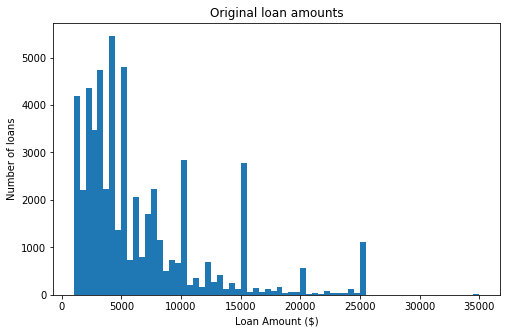

In [34]:
# Plot LoanOriginalAmount column
binsize = 500
bins = np.arange(loans['LoanOriginalAmount'].min(), loans['LoanOriginalAmount'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'LoanOriginalAmount', bins = bins)
plt.xlabel('Loan Amount ($)')
plt.ylabel('Number of loans')
plt.title('Original loan amounts')
plt.show()

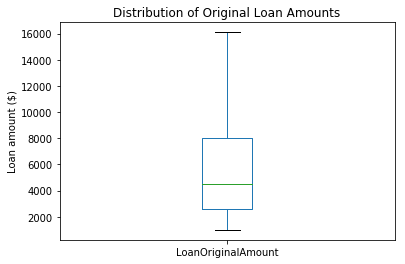

In [35]:
loans['LoanOriginalAmount'].plot(kind='box', showfliers=False)
plt.ylabel('Loan amount ($)')
plt.title('Distribution of Original Loan Amounts');

We can see that most loans are for under \\$6000 although there are spikes at \\$10000, \\$15000, \\$20000 and \\$25000. This is probably due to people taking out loans that round out to a convenient figure (here at \\$5000 intervals). The median is around \\$4500 and most loans fall between \\$2000 and \\$8000.

Due to the long tail we can also plot the Original Loan amounts on a log scale.

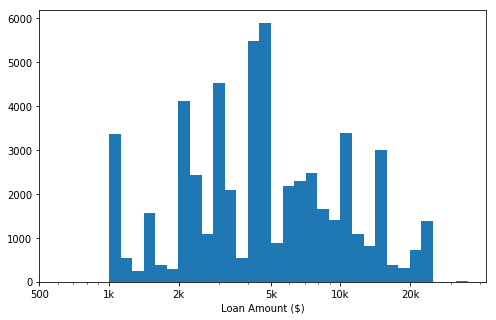

In [36]:
log_binsize = 0.05
bins = 10 ** np.arange(3, np.log10(loans['LoanOriginalAmount'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'LoanOriginalAmount', bins = bins)
plt.xscale('log')
plt.xticks([500, 1e3, 2e3, 5e3, 1e4, 2e4], [500, '1k', '2k', '5k', '10k', '20k'])
plt.xlabel('Loan Amount ($)')
plt.show()

The Original Loan Amount has a long tail with most of the amounts being below \\$6000 and a few higher amounts, with large spikes at each interval of \\$5000. The log of the Original Loan Amount consists if several large spikes at each $1k log Loan Amount.

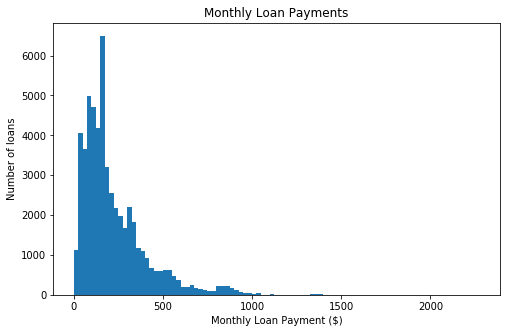

In [37]:
# Plot MonthlyLoanPayment column
binsize = 25
bins = np.arange(0, loans['MonthlyLoanPayment'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'MonthlyLoanPayment', bins = bins)
plt.xlabel('Monthly Loan Payment ($)')
plt.ylabel('Number of loans')
plt.title('Monthly Loan Payments')
plt.show()

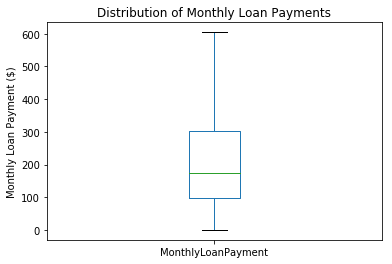

In [38]:
loans['MonthlyLoanPayment'].plot(kind='box', showfliers=False)
plt.ylabel('Monthly Loan Payment ($)')
plt.title('Distribution of Monthly Loan Payments');

We can see with the Monthly Loan Payments that they are also heavily right skewed. There is a spike around \\$200 per month and most payments are below \\$500 per month. Most payments fall between \\$100 and \\$300.

We can plot a log scale of Monthly Loan Payments as it shows a long tail.

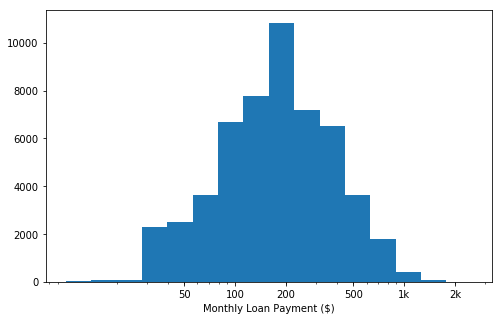

In [39]:
log_binsize = 0.15
bins = 10 ** np.arange(1, np.log10(loans['MonthlyLoanPayment'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'MonthlyLoanPayment', bins = bins)
plt.xscale('log')
plt.xticks([50, 100, 200, 500, 1000, 2000], [50, 100, 200, 500, '1k', '2k'])
plt.xlabel('Monthly Loan Payment ($)')
plt.show()

The Monthly Loan Payment has a long tail with most of the amounts being below \\$500 and a few higher amounts. The log of the Monthly Loan Payment shows a normal distibution with \\$200 being the median monthly payment.

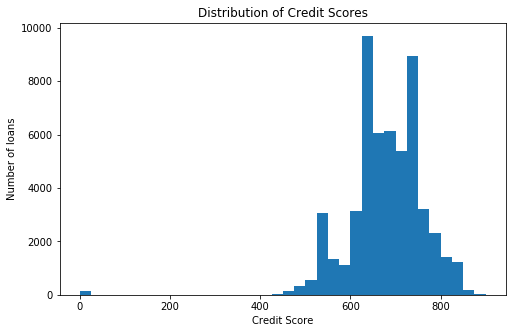

In [40]:
# Plot CreditScore column
binsize = 25
bins = np.arange(0, loans['CreditScore'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'CreditScore', bins = bins)
plt.xlabel('Credit Score')
plt.ylabel('Number of loans')
plt.title('Distribution of Credit Scores')
plt.show()

There are some Credit Scores that are close to 0. These outliers can be removed from the analysis.

In [41]:
# Select borrowers with a credit score of 0
zero_score = loans['CreditScore'] < 50
zero_score.sum()

133

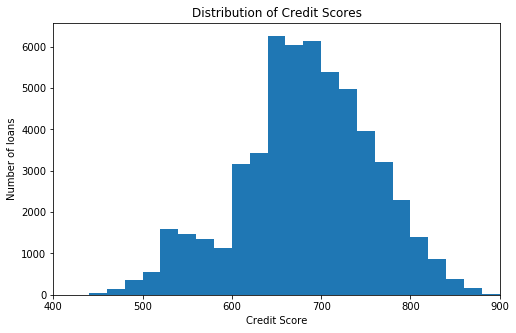

In [42]:
loans = loans.loc[-zero_score,:]

# Plot revised CreditScore column
binsize = 20
bins = np.arange(0, loans['CreditScore'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'CreditScore', bins = bins)
plt.xlabel('Credit Score')
plt.ylabel('Number of loans')
plt.title('Distribution of Credit Scores')
plt.xlim(400,900)
plt.show()

With the outlier credit scores removed we see that at the lower scores the data increases in spikes, levels out around 650 and then drops away fairly consistently to reach its max near 900.

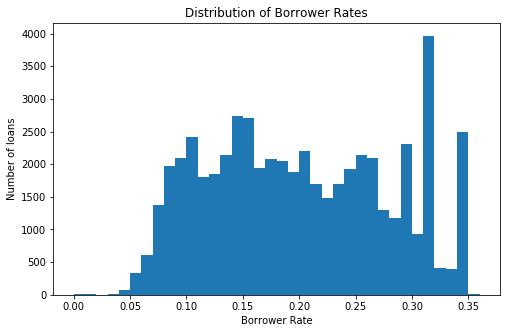

In [43]:
# Plot BorrowerRate column
binsize = 0.01
bins = np.arange(0, loans['BorrowerRate'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'BorrowerRate', bins = bins)
plt.xlabel('Borrower Rate')
plt.ylabel('Number of loans')
plt.title('Distribution of Borrower Rates')
plt.show()

The borrower rates are fairly evenly spread between around 0.08 to 0.3 with two spikes after this at around 3.2 and 3.5.

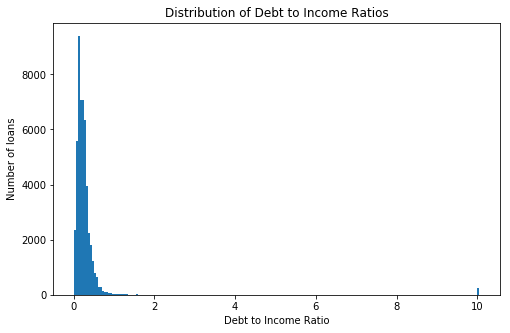

In [44]:
# Plot DebtToIncomeRatio column
binsize = 0.05
bins = np.arange(0, loans['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
plt.ylabel('Number of loans')
plt.title('Distribution of Debt to Income Ratios')
plt.show()

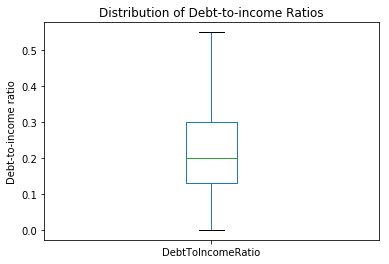

In [45]:
loans['DebtToIncomeRatio'].plot(kind='box', showfliers=False)
plt.ylabel('Debt-to-income ratio')
plt.title('Distribution of Debt-to-income Ratios');

There are a number of outliers above 10 (the highest allowed ratio) which make the graph difficult to read. I will remove these and plot the graph again.

In [46]:
outliers = loans['DebtToIncomeRatio'] > 9.5
outliers.sum()

248

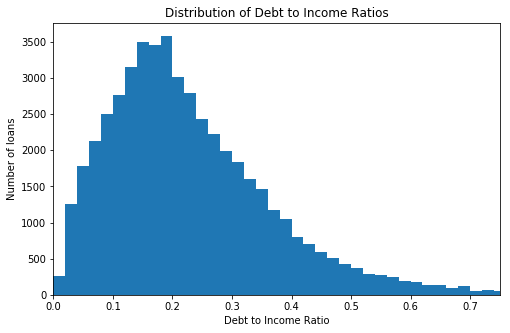

In [47]:
loans = loans.loc[-outliers,:]

# Replot DebtToIncomeRatio column
binsize = 0.02
bins = np.arange(0, loans['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
plt.ylabel('Number of loans')
plt.title('Distribution of Debt to Income Ratios')
plt.xlim(0,0.75)
plt.show()

Here we can see that the distribution is skewed to the right with most of the ratios being below 0.5. Most ratios are between 0.1 and 0.3.

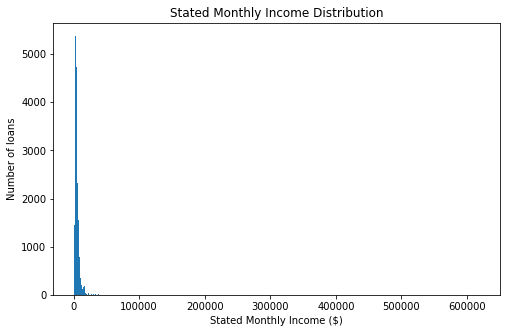

In [48]:
# Plot StatedMonthlyIncome column
binsize = 500
bins = np.arange(0, loans['StatedMonthlyIncome'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'StatedMonthlyIncome', bins = bins)
plt.xlabel('Stated Monthly Income ($)')
plt.ylabel('Number of loans')
plt.title('Stated Monthly Income Distribution')
plt.show()

Here we can see again a few outliers have made the graph very difficult to interpret. Let's try removing these outliers.

In [49]:
income_outliers = loans['StatedMonthlyIncome'] > 30000
income_outliers.sum()

141

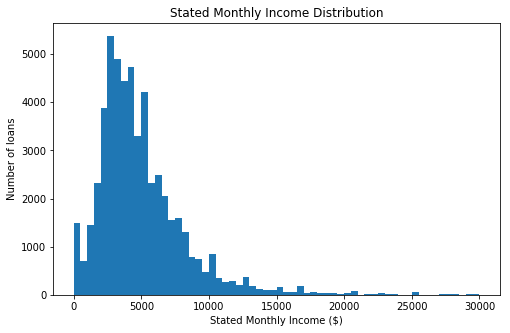

In [50]:
loans = loans.loc[-income_outliers,:]

# Replot the StatedMonthlyIncome graph
binsize = 500
bins = np.arange(0, loans['StatedMonthlyIncome'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'StatedMonthlyIncome', bins = bins)
plt.xlabel('Stated Monthly Income ($)')
plt.ylabel('Number of loans')
plt.title('Stated Monthly Income Distribution')
plt.show()

The plot now shows a right skew with most of the borrowers earning less than \\$30000 per month.

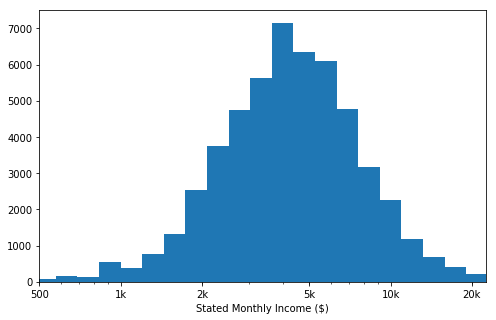

In [51]:
log_binsize = 0.08
bins = 10 ** np.arange(1, np.log10(loans['StatedMonthlyIncome'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'StatedMonthlyIncome', bins = bins)
plt.xscale('log')
plt.xticks([500, 1e3, 2e3, 5e3, 1e4, 2e4], [500, '1k', '2k', '5k', '10k', '20k'])
plt.xlabel('Stated Monthly Income ($)')
plt.xlim(500, 22500)
plt.show()

With a log transformation the Stated Monthly Income looks normal with the mean being around \\$5000.

We can look at the distribution of the number of loans per borrower by grouping by the MemberKey.

In [52]:
# Create a DataFrame holding the counts of loans per MemberKey
members = loans.groupby('MemberKey').size().reset_index(name='counts')

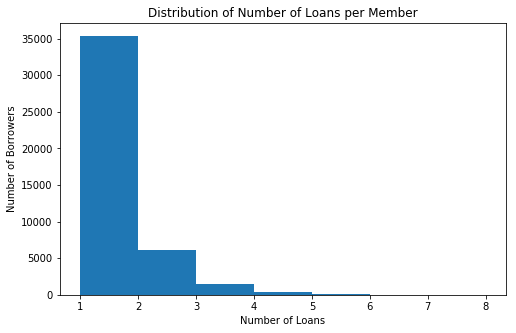

In [53]:
binsize = 1
bins = np.arange(1, members['counts'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = members, x = 'counts', bins = bins)
plt.xlabel('Number of Loans')
plt.ylabel('Number of Borrowers')
plt.title('Distribution of Number of Loans per Member')
plt.show()

We can also look at the proportion of number of loans per borrower.

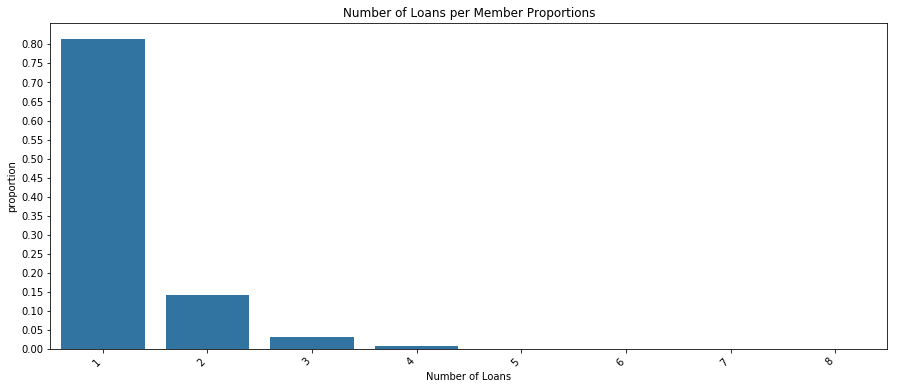

In [54]:
# Plot Loan counts column as %
plt.figure(figsize=[15,6])
n_points = members.shape[0]
cat_order = [1, 2, 3, 4, 5, 6, 7, 8]
max_count = members['counts'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
ax = sb.countplot(data = members, x = 'counts', color = base_color, order = cat_order)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Number of Loans')
plt.xticks(rotation = 45, horizontalalignment='right')
plt.title('Number of Loans per Member Proportions')
plt.show();

We can see from this that most (80%) of borrowers have only one finished loan, whether it was completed succesfully or not. A further 14% have two finished loans and around 4% have three. The highest number of finished loans is 8.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

70% of the loans were completed succesfully and 30% were not. Home ownership was split fairl evenly and most borrowers had one completed loan (80%) with 15% with 2 completed loans and around 4% with three. The original loan amounts were skewed to the right and tended to cluster around \\$5000 intervals suggesting that borrowers would take out a loan that was an interval of \\$5000. Monthly loan payments were also skewed to the right, however, after a log transformation these showed a normal distribution. Most monthly payments were below $500 with the average being around $200.

The Debt-to-income ratios were clearly right skewed with most being below 0.5. Listing Categories had a large number of Unknown and Other listings which make the feature less useful for analysis. Over a third were listed as Debt Consolidation so there is the possibility to look at the effect of Debt Consolidation on Loan Outcome compared to the other Listing Categories.

There was variation in the Loan Quarter Originations and a noticeable lack of loans generated between Q4 2008 and Q4 2009. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Some work was required to tidy the data. The EmploymentStatus column was not very helpful as it contained a large number of 'Employed' results, but then had separate levels of employment in the data also. I addressed this by converting 'Employed' members to 'Full-time' due to the fact that most employed members were in the 'Full-time' category.

There were outliers at the low end for Credit Score which I removed to make the plots clearer. Each of these had a low score of 0 and an upper socre of 19, which may reflect errors in the data. There were also outliers at the high end for StatedMonthlyIncome. I removed those that were above 30000 per month from the analysis to make the plots clearer. It is also reasonable to expect that some of these high values were inaccurate when considering the relatively small loan amounts they were for.

Several columns were converted to category types as these were appropriate to the form of the data (each contained clear categories). There were several entries that were missing data for a number of columns so I removed these. A small number of rows were missing the BorrowerAPR so replaced these with the mean for the column, as it was a very small percentage of rows that it was missing from.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!